In [1]:
import glob
from os import path
from time import perf_counter as clock

from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

import ppxf_example_kinematics_sauron as ppxf_ex

import pickle

In [2]:
def determine_goodpixels(ln_lam, lam_range_temp, z, width=800):
    """
    Generates a list of goodpixels to mask a given set of gas emission
    lines. This is meant to be used as input for pPXF.

    :param ln_lam: Natural logarithm np.log(wave) of the wavelength in
        Angstrom of each pixel of the log rebinned *galaxy* spectrum.
    :param lam_range_temp: Two elements vectors [lam_min_temp, lam_max_temp]
        with the minimum and maximum wavelength in Angstrom in the stellar
        *template* used in pPXF.
    :param z: Estimate of the galaxy redshift.
    :return: vector of goodpixels to be used as input for pPXF

    """
#                     -----[OII]-----    Hdelta   Hgamma   Hbeta   -----[OIII]-----   [OI]    -----[NII]-----   Halpha   -----[SII]-----   -----Na-----
    lines = np.array([3726.03, 3728.82, 4101.76, 4340.47, 4861.33, 4958.92, 5006.84, 6300.30, 6548.03, 6583.41, 6562.80, 6716.47, 6730.85, 5890., 5896.])
    dv = np.full_like(lines, width)  # width/2 of masked gas emission region in km/s
    c = 299792.458 # speed of light in km/s

    flag = False
    for line, dvj in zip(lines, dv):
        flag |= (ln_lam > np.log(line*(1 + z)) - dvj/c) \
              & (ln_lam < np.log(line*(1 + z)) + dvj/c)

    # Mask edges of stellar library
    flag |= ln_lam > np.log(lam_range_temp[1]*(1 + z)) - 900/c   
    flag |= ln_lam < np.log(lam_range_temp[0]*(1 + z)) + 900/c  

    return np.flatnonzero(~flag)


In [3]:
# spctX: spectrum to be analysed, Numpy array
# spctVarX: variance of spectrum, Numpy array
# lamVals: corresponding wavelengths (angstroms), Numpy array
# z: redshift, float, defaults to 0
# Na: Should sodium doublet be masked, boolean, defaults to True

def LOSVD_fit(spctX, spctVarX, lamVals, z=0.):

    ppxf_dir = path.dirname(path.realpath(util.__file__))

    #FWHM_gal = 5.835 * 10**-8 * lamVals**2 - 9.080 * 10**-4 * lamVals + 5.983   # Eqn from Bacon (2017)
    #FWHM_gal_const = np.median(FWHM_gal)                                              # For now, just assign one value of FWHM to the galaxy

    redshift = z

    galaxy, ln_lam1, velscale = util.log_rebin(lamVals, spctX)  # rebin spectrum into equal logarithmic bins
    galaxy = galaxy/np.median(galaxy)

    noise = np.sqrt(spctVarX)

    vazdekis = glob.glob(ppxf_dir + '/miles_models/Eun1.30*.fits')  # Will need new, higher-res template files at some point
    FWHM_tem = 2.51                                                 # Resolution of the default templates
    velscale_ratio = 1

    temp_hdu = fits.open(vazdekis[0])                               # Open one template to determine wavelength values
    ssp = temp_hdu[0].data
    h2 = temp_hdu[0].header
    lam2 = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    good_lam = (lam2 > lamVals[0]/1.02) & (lam2 < lamVals[-1]*1.02)
    ssp, lam2 = ssp[good_lam], lam2[good_lam]
    lamRange2 = [np.min(lam2), np.max(lam2)]
    sspNew, ln_lam2 = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)[:2]  # Log rebin template spectrum

    templates = np.empty((sspNew.size, len(vazdekis)))  # Templates go here

    #FWHM_dif = np.sqrt(FWHM_gal_const**2 - FWHM_tem**2)   # Determines the difference in FWHM between the obs and the template
    #sigma = FWHM_dif/2.355/h2['CDELT1']

    FWHM_gal_var = 5.835*10**-8 * (lam2*(1+z))**2 - 9.080*10**-4 * (lam2*(1+z)) +5.983
    FWHM_dif_var = np.sqrt((FWHM_gal_var**2 - FWHM_tem**2).clip(0)) # Determines the difference in FWHM between obs and template at all wavelengths - set to 0 if obs is better than template
    sigma_var = FWHM_dif_var/2.355/h2['CDELT1']



    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = util.gaussian_filter1d(ssp[good_lam], sigma_var)
        sspNew = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)[0]
        templates[:, j] = sspNew/np.median(sspNew[sspNew > 0]) 

    goodPixels = determine_goodpixels(ln_lam1, lamRange2, 0)    #changed from redshift

    c = 299792.458
    vel = 0 #c*np.log(1 + redshift)    # eq.(8) of Cappellari (2017, MNRAS)
    start = [vel, 100.]             # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, quiet=True, moments=4, 
              lam=np.exp(ln_lam1), lam_temp=np.exp(ln_lam2),
              degree=4, velscale_ratio=velscale_ratio)
    
    # The updated best-fitting redshift is given by the following
    # lines (using equation 8 of Cappellari 2017, MNRAS)
    """vcosm = c*np.log(1 + redshift)            # This is the initial redshift estimate
    vpec = pp.sol[0]                            # This is the fitted residual velocity
    vtot = vcosm + vpec                         # I add the two velocities before computing z
    redshift_best = np.exp(vtot/c) - 1          # eq.(8) Cappellari (2017)
    errors = pp.error*np.sqrt(pp.chi2)          # Assume the fit is good
    redshift_err = np.exp(vtot/c)*errors[0]/c   # Error propagation

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in errors))
    print('Elapsed time in pPXF: %.2f s' % (clock() - t))
    print(f"Best-fitting redshift z = {redshift_best:#.7f} "
        f"+/- {redshift_err:#.2g}")
    """
        
    return pp


    

In [4]:
file = 'IC3392_individual.fits'
hdu = fits.open(file)
spct = hdu[1].data
spcthead = hdu[1].header
spctVar = hdu[2].data

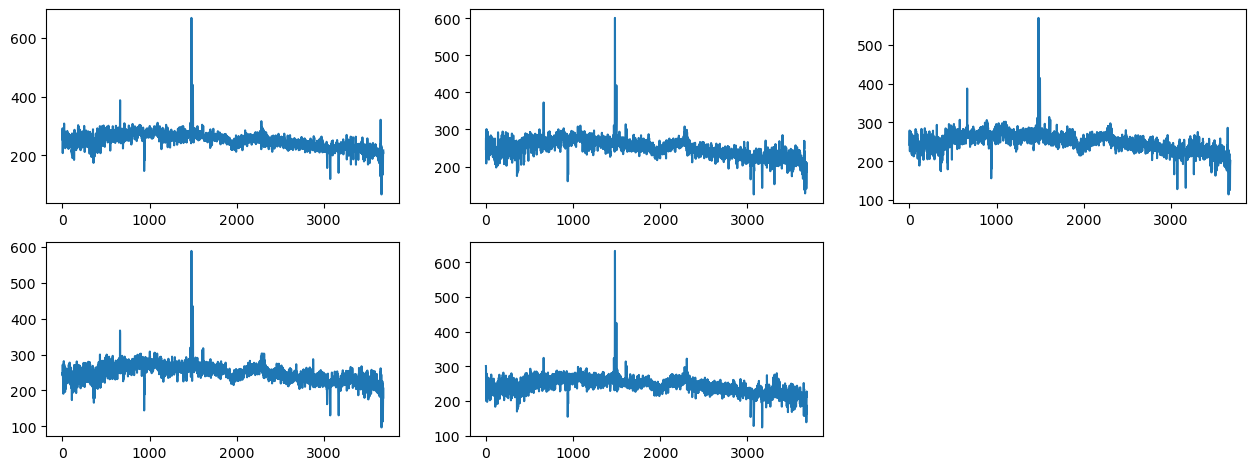

In [5]:
plt.subplot(2,3,1)
plt.plot(spct[0])

plt.subplot(2,3,2)
plt.plot(spct[1])

plt.subplot(2,3,3)
plt.plot(spct[2])

plt.subplot(2,3,4)
plt.plot(spct[3])

plt.subplot(2,3,5)
plt.plot(spct[4])

plt.subplots_adjust(right=2,top=1)
plt.show()

#They all appear to be very similar spectra

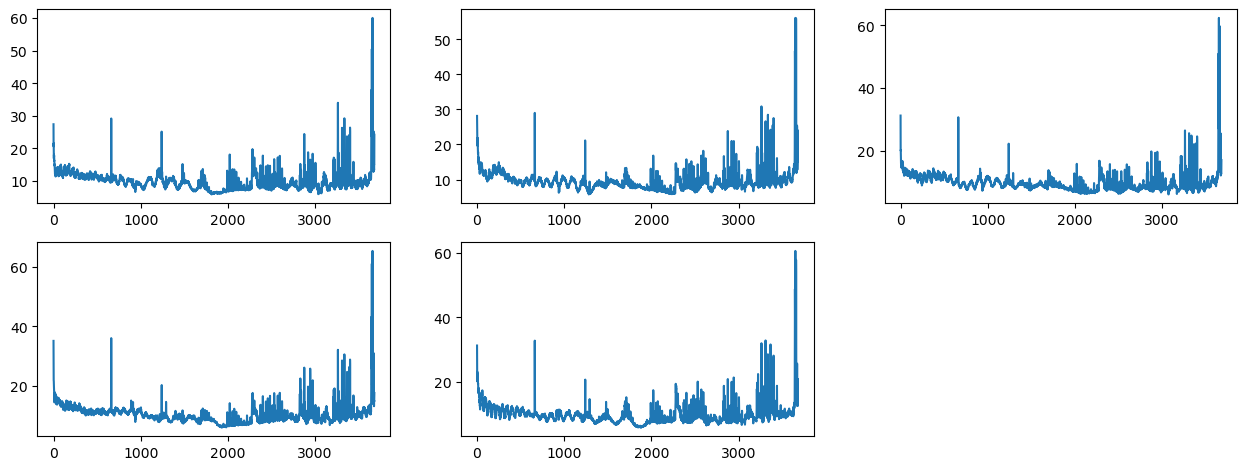

In [6]:
plt.subplot(2,3,1)
plt.plot(np.sqrt(spctVar[0]))

plt.subplot(2,3,2)
plt.plot(np.sqrt(spctVar[1]))

plt.subplot(2,3,3)
plt.plot(np.sqrt(spctVar[2]))

plt.subplot(2,3,4)
plt.plot(np.sqrt(spctVar[3]))

plt.subplot(2,3,5)
plt.plot(np.sqrt(spctVar[4]))

plt.subplots_adjust(right=2,top=1)
plt.show()

In [7]:
# need to determine the full range of wavelengths
#lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])
lamRange1 = spcthead['CRVAL3'] + np.array([0., spcthead['CD3_3']*(spcthead['NAXIS1']-1)])

lamVals = spcthead['CRVAL3'] + spcthead['CD3_3']*np.arange(spcthead['NAXIS1'])

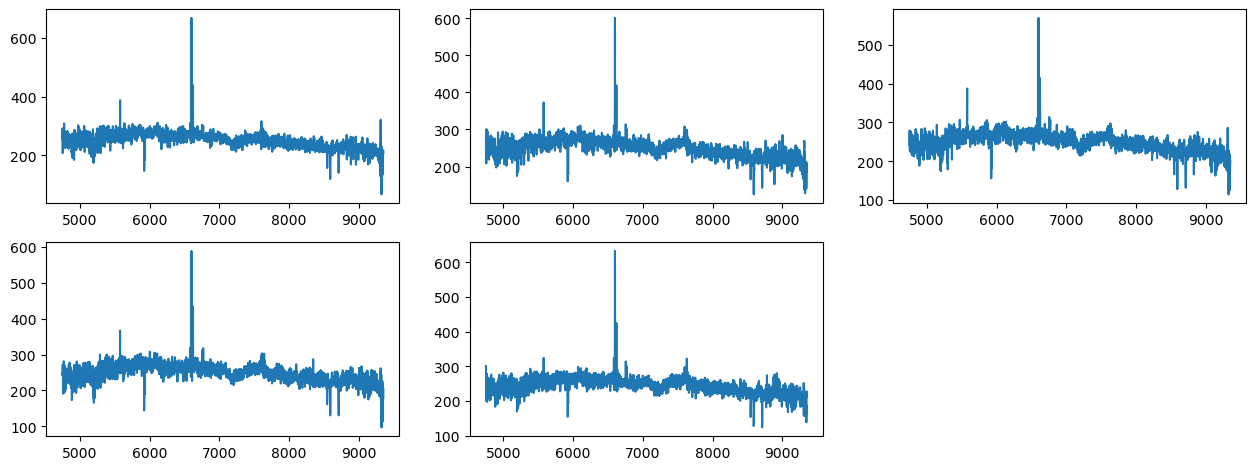

In [8]:
plt.subplot(2,3,1)
plt.plot(lamVals,spct[0])

plt.subplot(2,3,2)
plt.plot(lamVals,spct[1])

plt.subplot(2,3,3)
plt.plot(lamVals,spct[2])

plt.subplot(2,3,4)
plt.plot(lamVals,spct[3])

plt.subplot(2,3,5)
plt.plot(lamVals,spct[4])

plt.subplots_adjust(right=2,top=1)
plt.show()

In [9]:
spctX = spct[0]
spctVarX = spctVar[0]

In [10]:
screen = lamVals>4760
lamVals = lamVals[screen]
spctX = spctX[screen]
spctVarX = spctVarX[screen]

screen = lamVals<7000
lamVals = lamVals[screen]
spctX = spctX[screen]
spctVarX =spctVarX[screen]

lamVals /= (1+0.00557) #redshift correction

In [11]:
#4000/(1+0.00557)

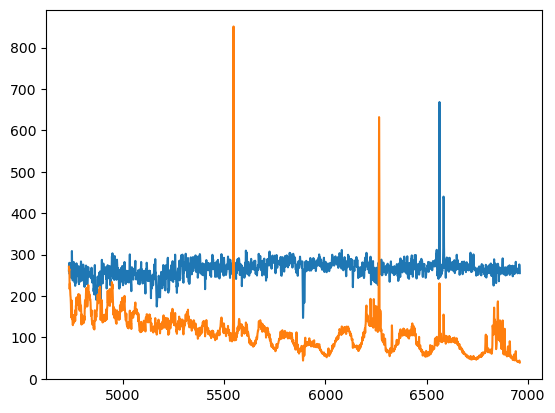

In [12]:
plt.plot(lamVals, spctX)
plt.plot(lamVals,spctVarX)
plt.show()

In [13]:
x=LOSVD_fit(spctX, spctVarX, lamVals, z=0.00557)

IndexError: list index out of range

[1.81297670e+01 4.33029396e+01 2.42026208e-02 1.67435093e-02]


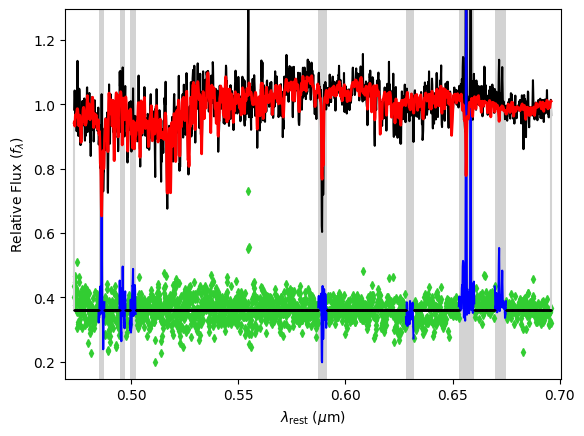

In [ ]:
print(x.sol)
x.plot()

In [ ]:

lamVals = spcthead['CRVAL3'] + spcthead['CD3_3']*np.arange(spcthead['NAXIS1'])
spct0 = spct[0]
spctVar0 = spctVar[0]
spct1 = spct[1]
spctVar1 = spctVar[1]
spct2 = spct[2]
spctVar2 = spctVar[2]
spct3 = spct[3]
spctVar3 = spctVar[3]
spct4 = spct[4]
spctVar4 = spctVar[4]

screen = lamVals>4760
lamVals = lamVals[screen]
spct0 = spct0[screen]
spct1 = spct1[screen]
spct2 = spct2[screen]
spct3 = spct3[screen]
spct4 = spct4[screen]
spctVar0 = spctVar0[screen]
spctVar1 = spctVar1[screen]
spctVar2 = spctVar2[screen]
spctVar3 = spctVar3[screen]
spctVar4 = spctVar4[screen]

screen = lamVals<7000
lamVals = lamVals[screen]
spct0 = spct0[screen]
spct1 = spct1[screen]
spct2 = spct2[screen]
spct3 = spct3[screen]
spct4 = spct4[screen]
spctVar0 = spctVar0[screen]
spctVar1 = spctVar1[screen]
spctVar2 = spctVar2[screen]
spctVar3 = spctVar3[screen]
spctVar4 = spctVar4[screen]

    

In [ ]:
x=LOSVD_fit(spct0, spctVar0, lamVals, z=0.00557)

In [ ]:
x=LOSVD_fit(spct1, spctVar1, lamVals, z=0.00557)

In [ ]:
x=LOSVD_fit(spct2, spctVar2, lamVals, z=0.00557)

In [ ]:
x=LOSVD_fit(spct3, spctVar3, lamVals, z=0.00557)

In [ ]:
x=LOSVD_fit(spct4, spctVar4, lamVals, z=0.00557)

[ 1.66802553e+03  6.45218533e-01 -1.54822234e-03 -1.44638321e-02]


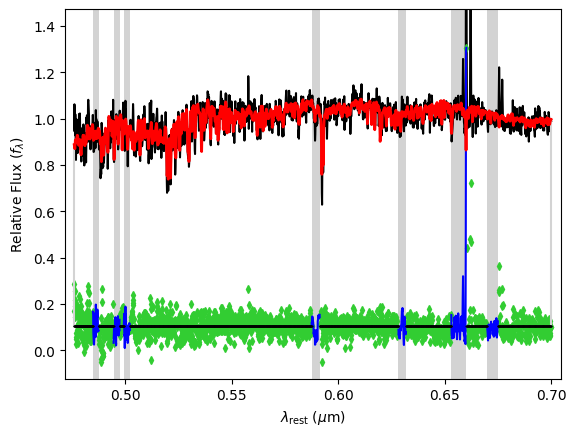

In [ ]:
print(x.sol)
x.plot()

In [ ]:
x.bestfit

array([0.89466737, 0.89847652, 0.89326647, ..., 0.99134536, 0.99352326,
       0.994068  ])

Now, we work with a snippet of a cube

In [ ]:
file = 'IC3392_subcube.fits'
hdu = fits.open(file)

spct = hdu[1].data
spcthead = hdu[1].header
spctVar = hdu[2].data

In [ ]:
lamVals = spcthead['CRVAL3'] + spcthead['CDELT3']*np.arange(spcthead['NAXIS3'])

In [ ]:
screen = lamVals>4760
lamVals = lamVals[screen]
spct = spct[screen,:,:]
spctVar = spctVar[screen,:,:]

screen = lamVals<7000
lamVals = lamVals[screen]
spct = spct[screen,:,:]
spctVar = spctVar[screen,:,:]
lamVals /= (1+0.00557)

spct.shape

(1792, 70, 70)

[ 7.37023692e+01  6.45218533e-01 -7.79178544e-05  7.14301224e-03]


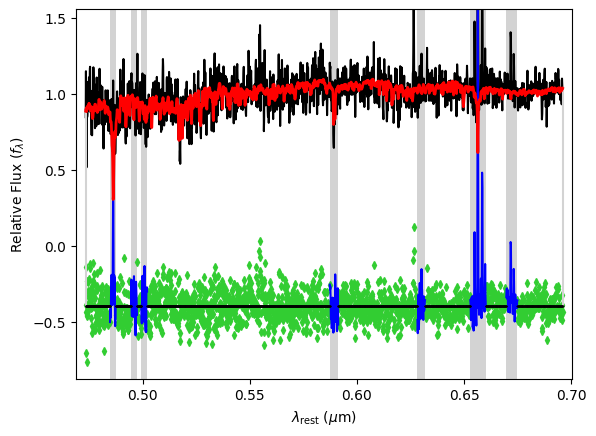

In [ ]:
spct0 = spct[:,35,35]
spctVar0 = spctVar[:,35,35]
x=LOSVD_fit(spct0, spctVar0, lamVals, z=0.00557)
print(x.sol)
x.plot()


In [ ]:
# 1x1 : 3.1s
# 2x2 : 11.2s
# 4x4 : 44.8s
# 8x8 : 3m 12.7s
# 16x16 : 12m 50.8s
# 35x35 : 61m 0.2s
# 70x70 : 258m 51.0s

size = 70
results = np.zeros((size,size,4))
for i in range(size):
    for j in range(size):
        pxlSpct = spct[:,i,j]
        pxlSpctVar = spctVar[:,i,j]
        x=LOSVD_fit(pxlSpct, pxlSpctVar, lamVals, z=0.00557)
        params = x.sol
        results[i,j] = params
    print('row ', str(i), ' done')

row  0  done
row  1  done
row  2  done
row  3  done
row  4  done
row  5  done
row  6  done
row  7  done
row  8  done
row  9  done
row  10  done
row  11  done
row  12  done
row  13  done
row  14  done
row  15  done
row  16  done
row  17  done
row  18  done
row  19  done
row  20  done
row  21  done
row  22  done
row  23  done
row  24  done
row  25  done
row  26  done
row  27  done
row  28  done
row  29  done
row  30  done
row  31  done
row  32  done
row  33  done
row  34  done
row  35  done
row  36  done
row  37  done
row  38  done
row  39  done
row  40  done
row  41  done
row  42  done
row  43  done
row  44  done
row  45  done
row  46  done
row  47  done
row  48  done
row  49  done
row  50  done
row  51  done
row  52  done
row  53  done
row  54  done
row  55  done
row  56  done
row  57  done
row  58  done
row  59  done
row  60  done
row  61  done
row  62  done
row  63  done
row  64  done
row  65  done
row  66  done
row  67  done
row  68  done
row  69  done


In [ ]:
output = open('IC3392_LOSVD_shifted.pkl', 'wb')
pickle.dump(results, output)
output.close()

In [ ]:
pkl_file = open('IC3392_LOSVD_shifted.pkl', 'rb')

loaded_results = pickle.load(pkl_file)

pkl_file.close()

In [ ]:
lRA = (12 + 28/60 + 44.305/3600) * 15
rRA = (12 + 28/60 + 43.352/3600) * 15
print(lRA, rRA)
RAVals = spcthead['CRVAL1'] - spcthead['CDELT1']*np.arange(spcthead['NAXIS1'])

187.18460416666667 187.18063333333333


In [ ]:
bDec = (15 + 0/60 + 00.14/3600)
dDec = (15 + 0/60 + 13.94/3600)
print(bDec,dDec)
DecVals = spcthead['CRVAL2'] - spcthead['CDELT2']*np.arange(spcthead['NAXIS2'])

15.00003888888889 15.003872222222222


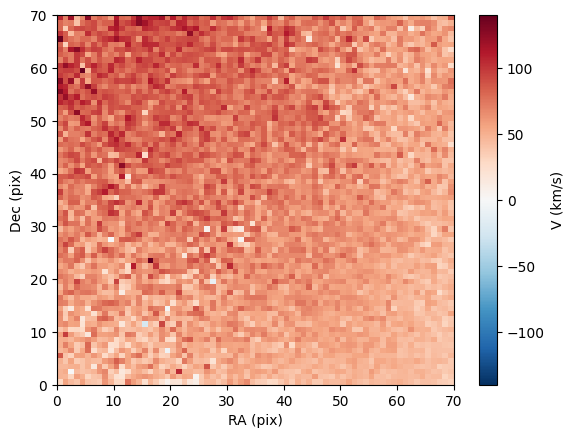

In [ ]:
plt.pcolormesh(loaded_results[:,:,0],cmap='RdBu_r',vmin=-140,vmax=140)
cbar=plt.colorbar()
cbar.set_label(r'V (km/s)')
plt.xlabel(r'RA (pix)')
#plt.xticks(np.linspace(0,69,2), np.linspace(round(rRA,4),round(lRA,4),2))
plt.ylabel(r'Dec (pix)')
#plt.savefig('IC3392_V_subtracted.png')
plt.show()

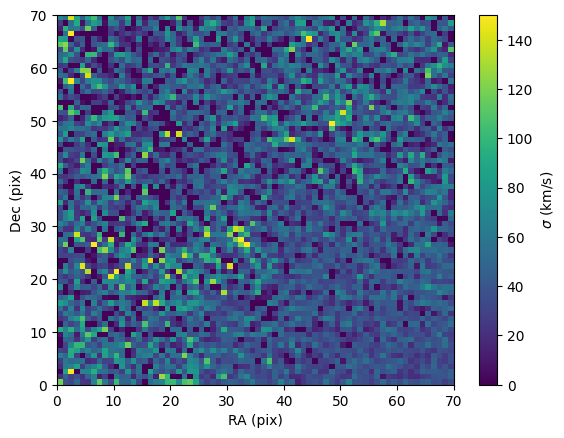

In [ ]:
plt.pcolormesh(loaded_results[:,:,1],cmap='viridis',vmin=0,vmax=150)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma$ (km/s)')
plt.xlabel(r'RA (pix)')
plt.ylabel(r'Dec (pix)')
#plt.savefig('IC3392_sigma_subtracted.png')
plt.show()

In [ ]:
residuals = np.zeros_like(spct)
size = 70
for i in range(size):
    for j in range(size):
        pxlSpct = spct[:,i,j]
        pxlSpctVar = spctVar[:,i,j]
        med = np.median(pxlSpct)
        x=LOSVD_fit(pxlSpct, pxlSpctVar, lamVals, z=0.00557)
        
        xbf = x.bestfit
        xres = pxlSpct - xbf*med
        residuals[:,i,j] = xres  
        
    print('row ', str(i), ' done')

hdu = fits.PrimaryHDU(residuals)

hdu.writeto('IC3392_subcube_residual.fits')

row  0  done
row  1  done
row  2  done
row  3  done
row  4  done
row  5  done
row  6  done
row  7  done
row  8  done
row  9  done
row  10  done
row  11  done
row  12  done
row  13  done
row  14  done
row  15  done
row  16  done
row  17  done
row  18  done
row  19  done
row  20  done
row  21  done
row  22  done
row  23  done
row  24  done
row  25  done
row  26  done
row  27  done
row  28  done
row  29  done
row  30  done
row  31  done
row  32  done
row  33  done
row  34  done
row  35  done
row  36  done
row  37  done
row  38  done
row  39  done
row  40  done
row  41  done
row  42  done
row  43  done
row  44  done
row  45  done
row  46  done
row  47  done
row  48  done
row  49  done
row  50  done
row  51  done
row  52  done
row  53  done
row  54  done
row  55  done
row  56  done
row  57  done
row  58  done
row  59  done
row  60  done
row  61  done
row  62  done
row  63  done
row  64  done
row  65  done
row  66  done
row  67  done
row  68  done
row  69  done


In [ ]:
hdu.writeto('junk.fits')

In [ ]:
spct0 = spct[:,0,0]
spctVar0 = spctVar[:,0,0]
x=LOSVD_fit(spct0, spctVar0, lamVals, z=0.00557)

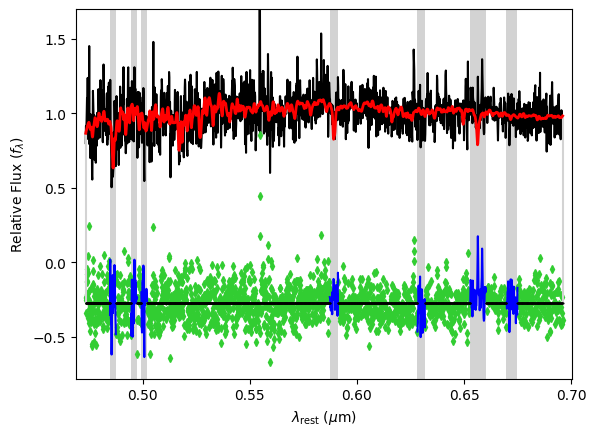

In [ ]:
x.plot()

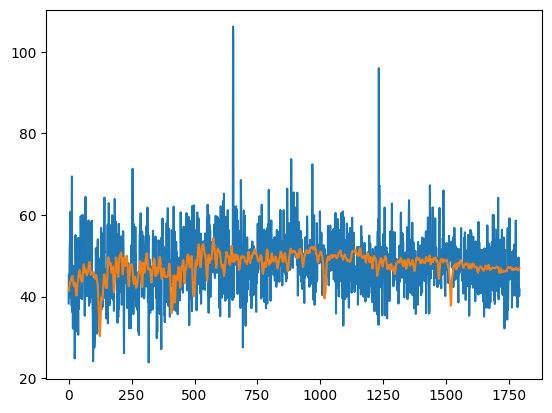

In [ ]:
xbf = x.bestfit
plt.plot(spct0)
plt.plot(xbf*np.median(spct0))

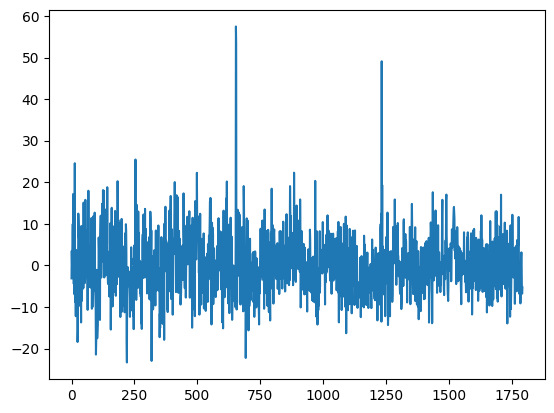

In [ ]:
xdiff = spct0 - xbf*np.median(spct0)
plt.plot(xdiff)

In [ ]:
file = 'IC3392_subcube_residual.fits'
hdu = fits.open(file)

res_spct = hdu[0].data

In [ ]:
ha_map = np.zeros_like(spct[0])
size = 70
for i in range(size):
    for j in range(size):
        acc = 0
        for l in range(1467,1480):
            acc += res_spct[l,i,j]
        ha_map[i,j] = acc
        
    print('row ', str(i), ' done')

hdu = fits.PrimaryHDU(ha_map)

hdu.writeto('IC3392_subcube_Halpha.fits')

row  0  done
row  1  done
row  2  done
row  3  done
row  4  done
row  5  done
row  6  done
row  7  done
row  8  done
row  9  done
row  10  done
row  11  done
row  12  done
row  13  done
row  14  done
row  15  done
row  16  done
row  17  done
row  18  done
row  19  done
row  20  done
row  21  done
row  22  done
row  23  done
row  24  done
row  25  done
row  26  done
row  27  done
row  28  done
row  29  done
row  30  done
row  31  done
row  32  done
row  33  done
row  34  done
row  35  done
row  36  done
row  37  done
row  38  done
row  39  done
row  40  done
row  41  done
row  42  done
row  43  done
row  44  done
row  45  done
row  46  done
row  47  done
row  48  done
row  49  done
row  50  done
row  51  done
row  52  done
row  53  done
row  54  done
row  55  done
row  56  done
row  57  done
row  58  done
row  59  done
row  60  done
row  61  done
row  62  done
row  63  done
row  64  done
row  65  done
row  66  done
row  67  done
row  68  done
row  69  done


In [ ]:
plt.pcolormesh(loaded_results[:,:,0],cmap='RdBu_r',vmin=-140,vmax=140)